Ye ab tak ka code:

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


def process_image(frame):
    
    def cal_undistort(img):
        # Reads mtx and dist matrices, peforms image distortion correction and returns the undistorted image

        import pickle

        # Read in the saved matrices
        my_dist_pickle = pickle.load( open( "output_files/calib_pickle_files/dist_pickle.p", "rb" ) )
        mtx = my_dist_pickle["mtx"]
        dist = my_dist_pickle["dist"]

        img_size = (img.shape[1], img.shape[0])    

        undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
        #undistorted_img =  cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)   #Use if you use cv2 to import image. ax.imshow() needs RGB image
        return undistorted_img

    
    def yellow_threshold(img, sxbinary):
        # Convert to HLS color space and separate the S channel
        # Note: img is the undistorted image
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        h_channel = hls[:,:,0]
        # Threshold color channel
        s_thresh_min = 100
        s_thresh_max = 255
        
        #for 360 degree, my value for yellow ranged between 35 and 50. So uska half kar diya
        h_thresh_min = 10    
        h_thresh_max = 25

        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

        h_binary = np.zeros_like(h_channel)
        h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1

        # Combine the two binary thresholds
        yellow_binary = np.zeros_like(s_binary)
        yellow_binary[(((s_binary == 1) | (sxbinary == 1) ) & (h_binary ==1))] = 1
        return yellow_binary
    
    def xgrad_binary(img, thresh_min=30, thresh_max=100):
        # Grayscale image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Sobel x
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        # Threshold x gradient
        #thresh_min = 30    #Already given above
        #thresh_max = 100

        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        return sxbinary
    
    def white_threshold(img, sxbinary, lower_white_thresh = 170):
        r_channel = img[:,:,0]
        g_channel = img[:,:,1]
        b_channel = img[:,:,2]
        # Threshold color channel
        r_thresh_min = lower_white_thresh
        r_thresh_max = 255
        r_binary = np.zeros_like(r_channel)
        r_binary[(r_channel >= r_thresh_min) & (r_channel <= r_thresh_max)] = 1
        
        g_thresh_min = lower_white_thresh
        g_thresh_max = 255
        g_binary = np.zeros_like(g_channel)
        g_binary[(g_channel >= g_thresh_min) & (g_channel <= g_thresh_max)] = 1

        b_thresh_min = lower_white_thresh
        b_thresh_max = 255
        b_binary = np.zeros_like(b_channel)
        b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

        white_binary = np.zeros_like(r_channel)
        white_binary[((r_binary ==1) & (g_binary ==1) & (b_binary ==1) & (sxbinary==1))] = 1
        return white_binary
        
    def thresh_img(img):
                       
       
        #sxbinary = xgrad_binary(img, thresh_min=30, thresh_max=100)
        sxbinary = xgrad_binary(img, thresh_min=25, thresh_max=130)
        yellow_binary = yellow_threshold(img, sxbinary)     #(((s) | (sx)) & (h))
        white_binary = white_threshold(img, sxbinary, lower_white_thresh = 150)
        
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[((yellow_binary == 1) | (white_binary == 1))] = 1
        
        out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
        
        return out_img
    
    def perspective_transform(img):
    
        # Define calibration box in source (original) and destination (desired or warped) coordinates

        img_size = (img.shape[1], img.shape[0])
        """Notice the format used for img_size. Yaha bhi ulta hai. x axis aur fir y axis chahiye. 
              Apne format mein rows(y axis) and columns (x axis) hain"""


        # Four source coordinates
        # Order of points: top left, top right, bottom right, bottom left
        
        src = np.array(
            [[435*img.shape[1]/960, 350*img.shape[0]/540],
             [530*img.shape[1]/960, 350*img.shape[0]/540],
             [885*img.shape[1]/960, img.shape[0]],
             [220*img.shape[1]/960, img.shape[0]]], dtype='f')
        

        # Next, we'll define a desired rectangle plane for the warped image.
        # We'll choose 4 points where we want source points to end up 
        # This time we'll choose our points by eyeballing a rectangle

        dst = np.array(
            [[290*img.shape[1]/960, 0],
             [740*img.shape[1]/960, 0],
             [740*img.shape[1]/960, img.shape[0]],
             [290*img.shape[1]/960, img.shape[0]]], dtype='f')


        #Compute the perspective transform, M, given source and destination points:
        M = cv2.getPerspectiveTransform(src, dst)

        #Warp an image using the perspective transform, M; using linear interpolation    
        #Interpolating points is just filling in missing points as it warps an image
        # The input image for this function can be a colored image too
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
              
        return warped, src, dst 

    def rev_perspective_transform(img, src, dst):

        img_size = (img.shape[1], img.shape[0])

        #Compute the perspective transform, M, given source and destination points:
        Minv = cv2.getPerspectiveTransform(dst, src)

        #Warp an image using the perspective transform, M; using linear interpolation    
        #Interpolating points is just filling in missing points as it warps an image
        # The input image for this function can be a colored image too
        un_warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
              
        return un_warped 

    
    def draw_polygon(img1, img2, src, dst):
        src = src.astype(int)  #Very important step (Pixels cannot be in decimals)
        dst = dst.astype(int)
        cv2.polylines(img1, [src], True, (255,0,0), 3)
        cv2.polylines(img2, [dst], True, (255,0,0), 3)
    
    def histogram_bottom_peaks (warped_img):
        # This will detect the bottom point of our lane lines
        
        # Take a histogram of the bottom half of the image
        bottom_half = warped_img[((2*warped_img.shape[0])//5):,:,0]     # Collecting all pixels in the bottom half
        histogram = np.sum(bottom_half, axis=0)                         # Summing them along y axis (or along columns)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)        # 1D array hai histogram toh uska bas 0th index filled hoga 
        #print(np.shape(histogram))     #OUTPUT:(1280,)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        return leftx_base, rightx_base
    
    def find_lane_pixels(warped_img):
    
        leftx_base, rightx_base = histogram_bottom_peaks(warped_img)
   
        
        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin. So width = 2*margin 
        margin = 90
        # Set minimum number of pixels found to recenter window
        minpix = 1000    #I've changed this from 50 as given in lectures
    
        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(warped_img.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped_img.nonzero()  #pixel ke coordinates dega 2 seperate arrays mein
        nonzeroy = np.array(nonzero[0])    # Y coordinates milenge 1D array mein. They will we arranged in the order of pixels
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base         #initially set kar diya hai. For loop ke end mein change karenge
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []   # Ismein lane-pixels ke indices collect karenge. 
                              # 'nonzerox' array mein index daalke coordinate mil jaayega
        right_lane_inds = []  

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped_img.shape[0] - (window+1)*window_height
            win_y_high = warped_img.shape[0] - window*window_height
            """### TO-DO: Find the four below boundaries of the window ###"""
            win_xleft_low = leftx_current - margin  
            win_xleft_high = leftx_current + margin  
            win_xright_low = rightx_current - margin  
            win_xright_high = rightx_current + margin 
            
            """
            # Create an output image to draw on and visualize the result
            out_img = np.copy(warped_img)
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
            """

            ### TO-DO: Identify the nonzero pixels in x and y within the window ###
            #Iska poora explanation seperate page mein likha hai
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]


            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on the mean position of the pixels in your current window (re-centre)
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        """return leftx, lefty, rightx, righty, out_img""" #agar rectangles bana rahe ho toh out_image rakhna
        return leftx, lefty, rightx, righty
        

    def fit_polynomial(warped_img, leftx, lefty, rightx, righty, right_history):
    
        #Fit a second order polynomial to each using `np.polyfit` ###
        left_fit = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)

        # Generate x and y values for plotting. 
        #NOTE: y is the independent variable. Refer "fit polynomial" notes for explanation
        # We'll plot x as a function of y
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        
        # Eqn of parabola: a(x**2) + bx + c. Where a and b denote the shape of parabola. Shape of parabola will be amost constant inn our case 
        
        try:        
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            
            if(right_history == None):
                a2 = (0.6*left_fit[0] + 0.4*right_fit[0])
                b2 = (0.6*left_fit[1] + 0.4*right_fit[1])
                c2 = (warped_img.shape[1] - (left_fit[0]*(warped_img.shape[0]-1)**2 + left_fit[1]*(warped_img.shape[0]-1) + left_fit[2]))*0.1 + 0.9*right_fit[2]

            else:
                a2_new = (0.6*left_fit[0] + 0.4*right_fit[0])
                b2_new = (0.6*left_fit[1] + 0.4*right_fit[1])  
                c2_new = (warped_img.shape[1] - (left_fit[0]*(warped_img.shape[0]-1)**2 + left_fit[1]*(warped_img.shape[0]-1) + left_fit[2]))*0.1 + 0.9*right_fit[2]
                
                # Finding weighted average for the previous elements data within right_history
                a2_old= sum([(0.2*(index+1)*element[0]) for index,element in enumerate(right_history)])/sum([0.2*(index+1) for index in range(0,5)])        
                b2_old= sum([(0.2*(index+1)*element[1]) for index,element in enumerate(right_history)])/sum([0.2*(index+1) for index in range(0,5)])       
                c2_old= sum([(0.2*(index+1)*element[2]) for index,element in enumerate(right_history)])/sum([0.2*(index+1) for index in range(0,5)])
                
                
                """yaha ke coefficients variance se aa sakte hain"""
                a2= a2_new*0.8 + a2_old*0.2
                b2= b2_new*0.8 + b2_old*0.2
                c2= c2_new*0.8 + c2_old*0.2
            
            right_fitx = a2*ploty**2 + b2*ploty + c2
            
            status = True
        
        #try:
        #    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        #    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
                
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty
            status = False

        
        return left_fit, [a2,b2,c2], left_fitx, right_fitx, status
        # out_img here has boxes drawn and the pixels are colored 
    
    def color_pixels_and_curve(out_img, leftx, lefty, rightx, righty, left_fitx, right_fitx):
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
        # Converting the coordinates of our line into integer values as index of the image can't take decimals
        left_fitx_int = left_fitx.astype(np.int32)
        right_fitx_int = right_fitx.astype(np.int32)
        ploty_int = ploty.astype(np.int32)
        
        # Coloring the curve as yellow
        out_img[ploty_int,left_fitx_int] = [255,255,0]
        out_img[ploty_int,right_fitx_int] = [255,255,0]
        
        # To thicken the curve
        out_img[ploty_int,left_fitx_int+1] = [255,255,0]
        out_img[ploty_int,right_fitx_int+1] = [255,255,0]
        out_img[ploty_int,left_fitx_int-1] = [255,255,0]
        out_img[ploty_int,right_fitx_int-1] = [255,255,0]
        out_img[ploty_int,left_fitx_int+2] = [255,255,0]
        out_img[ploty_int,right_fitx_int+2] = [255,255,0]
        out_img[ploty_int,left_fitx_int-2] = [255,255,0]
        out_img[ploty_int,right_fitx_int-2] = [255,255,0]
        
        
        
    def search_around_poly(warped_img, left_fit, right_fit):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 100

        # Grab activated pixels
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty

    def modify_array(array, new_value):
        if len(array)!=5:
            for i in range(0,5):
                array.append(new_value)

        else:
            dump_var=array[0]
            array[0]=array[1]
            array[1]=array[2]
            array[2]=array[3]
            array[3]=array[4]
            array[4]=new_value
        return array

    undist_img = cal_undistort(frame)
    thresh_img = thresh_img(undist_img)    # Note: This is not a binary iamge. It has been stacked already within the function
    warped_img, src, dst = perspective_transform(thresh_img)

    #draw_polygon(frame, warped_img, src, dst)   #the first image is the original image that you import into the system
    
    print(lane.count)
    if (lane.count == 0):
        leftx, lefty, rightx, righty = find_lane_pixels(warped_img)     # Find our lane pixels first
        left_fit, right_fit, left_fitx, right_fitx, status = fit_polynomial(warped_img, leftx, lefty, rightx, righty, right_history=None)
        
    elif (lane.count > 0):
        
        left_fit_previous = [i[0] for i in lane.curve_fit] 
        right_fit_previous = [i[1] for i in lane.curve_fit]
        #print(left_fit_previous)
        #print(right_fit_previous)
        leftx, lefty, rightx, righty = search_around_poly(warped_img, left_fit_previous[4], right_fit_previous[4])
        left_fit, right_fit, left_fitx, right_fitx, status = fit_polynomial(warped_img, leftx, lefty, rightx, righty, right_history=right_fit_previous)
        
    color_pixels_and_curve(warped_img, leftx, lefty, rightx, righty, left_fitx, right_fitx)
    
    lane.count = lane.count+1
    lane.detected = status
    lane.curve_fit = modify_array(lane.curve_fit,[left_fit, right_fit])
    
    #lane.current_xfitted.append([left_fitx, right_fitx])
    #lane.allx.append([leftx,rightx])
    #lane.ally.append([lefty, righty])
    #lane.image_output.append(warped_img)
    
    unwarped_img = rev_perspective_transform(warped_img, src, dst)
    
    return unwarped_img
    
    

Let's try classes

0
1
2
3


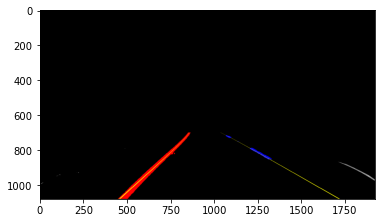

In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #Let's count the number of consecutive frames
        self.count = 0
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients for the most recent fit
        self.curve_fit = []  
        # x values of the curve that we fit intially
        #self.current_xfitted = []
        # x values for detected line pixels
        #self.allx = []  
        # y values for detected line pixels
        #self.ally = []
        #store your image in this
        #self.image_output = []
        
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        
        
lane=Line()


frame1= mpimg.imread("my_test_images/Highway_snaps/image (1).jpg")
frame2= mpimg.imread("my_test_images/Highway_snaps/image (2).jpg")
frame3= mpimg.imread("my_test_images/Highway_snaps/image (3).jpg")


(process_image(frame1))
(process_image(frame2))
plt.imshow(process_image(frame3))

print(lane.count)

#print(np.shape(lane.image_output))
#plt.imshow(lane.image_output[2])


Videoo test



In [3]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #Let's count the number of consecutive frames
        self.count = 0
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients for the most recent fit
        self.curve_fit = []  
        # x values of the curve that we fit intially
        #self.current_xfitted = []
        # x values for detected line pixels
        #self.allx = []  
        # y values for detected line pixels
        #self.ally = []
        #store your image in this
        #self.image_output = []
        
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')      
        
lane=Line()

project_output = 'output_files/video_clips/project_video_with_history_FULL.mp4'

clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(38,44)

project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images! 
%time project_clip.write_videofile(project_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

0
Moviepy - Building video output_files/video_clips/project_video_with_history_FULL.mp4.
Moviepy - Writing video output_files/video_clips/project_video_with_history_FULL.mp4

1


t:   0%|          | 3/1260 [00:00<05:43,  3.66it/s, now=None]

2


t:   0%|          | 4/1260 [00:01<06:02,  3.46it/s, now=None]

3


t:   0%|          | 5/1260 [00:01<06:02,  3.46it/s, now=None]

4


t:   0%|          | 6/1260 [00:01<05:46,  3.62it/s, now=None]

5


t:   1%|          | 7/1260 [00:01<05:18,  3.94it/s, now=None]

6
7

t:   1%|          | 8/1260 [00:02<05:16,  3.95it/s, now=None]

t:   1%|          | 9/1260 [00:02<05:18,  3.93it/s, now=None]

8
9


t:   1%|          | 11/1260 [00:02<04:40,  4.45it/s, now=None]

10
11


t:   1%|          | 13/1260 [00:03<04:16,  4.86it/s, now=None]

12
13

t:   1%|          | 14/1260 [00:03<04:20,  4.79it/s, now=None]

t:   1%|          | 15/1260 [00:03<04:19,  4.79it/s, now=None]

14


t:   1%|▏         | 16/1260 [00:03<04:17,  4.84it/s, now=None]

15
16

t:   1%|▏         | 17/1260 [00:04<04:20,  4.77it/s, now=None]


17

t:   1%|▏         | 18/1260 [00:04<04:19,  4.78it/s, now=None]

t:   2%|▏         | 19/1260 [00:04<04:22,  4.73it/s, now=None]

18
19

t:   2%|▏         | 20/1260 [00:04<04:17,  4.81it/s, now=None]


20

t:   2%|▏         | 21/1260 [00:04<04:16,  4.83it/s, now=None]


21

t:   2%|▏         | 22/1260 [00:05<04:14,  4.86it/s, now=None]


22

t:   2%|▏         | 23/1260 [00:05<04:17,  4.81it/s, now=None]

t:   2%|▏         | 24/1260 [00:05<04:20,  4.75it/s, now=None]

23


t:   2%|▏         | 25/1260 [00:05<04:19,  4.76it/s, now=None]

24
25


t:   2%|▏         | 27/1260 [00:06<04:09,  4.94it/s, now=None]

26
27


t:   2%|▏         | 29/1260 [00:06<04:10,  4.91it/s, now=None]

28
29


t:   2%|▏         | 31/1260 [00:06<04:01,  5.09it/s, now=None]

30
31

t:   3%|▎         | 32/1260 [00:07<03:58,  5.14it/s, now=None]

t:   3%|▎         | 33/1260 [00:07<04:07,  4.96it/s, now=None]

32
33

t:   3%|▎         | 34/1260 [00:07<04:04,  5.00it/s, now=None]


34


t:   3%|▎         | 36/1260 [00:07<03:48,  5.37it/s, now=None]

35
36


t:   3%|▎         | 38/1260 [00:08<04:13,  4.82it/s, now=None]

37


t:   3%|▎         | 39/1260 [00:08<04:55,  4.13it/s, now=None]

38
39


t:   3%|▎         | 40/1260 [00:08<04:34,  4.45it/s, now=None]

40


t:   3%|▎         | 42/1260 [00:09<04:06,  4.93it/s, now=None]

41


t:   3%|▎         | 43/1260 [00:09<04:41,  4.33it/s, now=None]

42


t:   3%|▎         | 44/1260 [00:09<04:33,  4.44it/s, now=None]

43
44

t:   4%|▎         | 45/1260 [00:09<04:24,  4.60it/s, now=None]


45

t:   4%|▎         | 46/1260 [00:10<04:12,  4.80it/s, now=None]


46

t:   4%|▎         | 47/1260 [00:10<04:03,  4.98it/s, now=None]


47


t:   4%|▍         | 49/1260 [00:10<04:19,  4.67it/s, now=None]

48


t:   4%|▍         | 50/1260 [00:10<04:34,  4.41it/s, now=None]

49
50


t:   4%|▍         | 52/1260 [00:11<04:12,  4.78it/s, now=None]

51
52

t:   4%|▍         | 53/1260 [00:11<04:14,  4.74it/s, now=None]


53

t:   4%|▍         | 54/1260 [00:11<04:08,  4.86it/s, now=None]


54

t:   4%|▍         | 55/1260 [00:11<04:05,  4.92it/s, now=None]


55

t:   4%|▍         | 56/1260 [00:12<03:57,  5.06it/s, now=None]


56

t:   5%|▍         | 57/1260 [00:12<03:53,  5.15it/s, now=None]


57


t:   5%|▍         | 59/1260 [00:12<04:02,  4.94it/s, now=None]

58
59

t:   5%|▍         | 60/1260 [00:12<04:05,  4.88it/s, now=None]


60

t:   5%|▍         | 61/1260 [00:13<04:00,  4.98it/s, now=None]


61


t:   5%|▌         | 63/1260 [00:13<04:41,  4.26it/s, now=None]

62


t:   5%|▌         | 64/1260 [00:13<04:16,  4.67it/s, now=None]

63
64

t:   5%|▌         | 65/1260 [00:13<04:03,  4.90it/s, now=None]


65


t:   5%|▌         | 67/1260 [00:14<03:46,  5.26it/s, now=None]

66
67

t:   5%|▌         | 68/1260 [00:14<03:52,  5.12it/s, now=None]


68

t:   5%|▌         | 69/1260 [00:14<03:51,  5.14it/s, now=None]


69

t:   6%|▌         | 70/1260 [00:14<03:48,  5.22it/s, now=None]


70

t:   6%|▌         | 71/1260 [00:15<03:46,  5.24it/s, now=None]


71

t:   6%|▌         | 72/1260 [00:15<03:47,  5.21it/s, now=None]


72

t:   6%|▌         | 73/1260 [00:15<03:51,  5.12it/s, now=None]


73

t:   6%|▌         | 74/1260 [00:15<03:50,  5.15it/s, now=None]


74

t:   6%|▌         | 75/1260 [00:15<03:45,  5.25it/s, now=None]

t:   6%|▌         | 76/1260 [00:16<04:16,  4.61it/s, now=None]

75
76

t:   6%|▌         | 77/1260 [00:16<04:04,  4.83it/s, now=None]


77


t:   6%|▋         | 79/1260 [00:16<04:13,  4.65it/s, now=None]

78
79

t:   6%|▋         | 80/1260 [00:16<04:14,  4.64it/s, now=None]

t:   6%|▋         | 81/1260 [00:17<04:09,  4.73it/s, now=None]

80


t:   7%|▋         | 82/1260 [00:17<04:04,  4.82it/s, now=None]

81
82


t:   7%|▋         | 84/1260 [00:17<03:52,  5.05it/s, now=None]

83
84


t:   7%|▋         | 86/1260 [00:18<04:18,  4.55it/s, now=None]

85
86


t:   7%|▋         | 88/1260 [00:18<04:17,  4.54it/s, now=None]

87
88

t:   7%|▋         | 89/1260 [00:18<03:59,  4.89it/s, now=None]


89


t:   7%|▋         | 91/1260 [00:19<03:45,  5.18it/s, now=None]

90
91

t:   7%|▋         | 92/1260 [00:19<04:04,  4.79it/s, now=None]

t:   7%|▋         | 93/1260 [00:19<04:05,  4.75it/s, now=None]

92
93


t:   8%|▊         | 95/1260 [00:19<03:39,  5.30it/s, now=None]

94
95


t:   8%|▊         | 97/1260 [00:20<03:22,  5.75it/s, now=None]

96
97


t:   8%|▊         | 99/1260 [00:20<03:19,  5.82it/s, now=None]

98
99


t:   8%|▊         | 101/1260 [00:20<03:13,  5.99it/s, now=None]

100
101


t:   8%|▊         | 103/1260 [00:21<03:31,  5.47it/s, now=None]

102
103

t:   8%|▊         | 104/1260 [00:21<03:29,  5.52it/s, now=None]


104


t:   8%|▊         | 106/1260 [00:21<04:02,  4.75it/s, now=None]

105


t:   8%|▊         | 107/1260 [00:22<04:01,  4.78it/s, now=None]

106
107

t:   9%|▊         | 108/1260 [00:22<04:26,  4.32it/s, now=None]

t:   9%|▊         | 109/1260 [00:22<04:42,  4.07it/s, now=None]

108
109


t:   9%|▉         | 111/1260 [00:23<04:03,  4.71it/s, now=None]

110
111


t:   9%|▉         | 113/1260 [00:23<03:37,  5.27it/s, now=None]

112
113


t:   9%|▉         | 115/1260 [00:23<03:29,  5.46it/s, now=None]

114
115


t:   9%|▉         | 117/1260 [00:24<03:16,  5.82it/s, now=None]

116
117


t:   9%|▉         | 119/1260 [00:24<03:08,  6.07it/s, now=None]

118
119


t:  10%|▉         | 121/1260 [00:24<03:03,  6.22it/s, now=None]

120
121


t:  10%|▉         | 123/1260 [00:25<03:00,  6.31it/s, now=None]

122
123


t:  10%|▉         | 125/1260 [00:25<03:02,  6.23it/s, now=None]

124
125


t:  10%|█         | 127/1260 [00:25<03:25,  5.51it/s, now=None]

126
127


t:  10%|█         | 129/1260 [00:26<03:44,  5.05it/s, now=None]

128
129

t:  10%|█         | 130/1260 [00:26<03:34,  5.27it/s, now=None]


130


t:  10%|█         | 132/1260 [00:26<03:37,  5.18it/s, now=None]

131
132

t:  11%|█         | 133/1260 [00:26<03:33,  5.29it/s, now=None]


133


t:  11%|█         | 135/1260 [00:27<03:31,  5.32it/s, now=None]

134
135


t:  11%|█         | 137/1260 [00:27<03:51,  4.85it/s, now=None]

136
137


t:  11%|█         | 139/1260 [00:28<03:57,  4.71it/s, now=None]

138


t:  11%|█         | 140/1260 [00:28<03:50,  4.86it/s, now=None]

139
140


t:  11%|█▏        | 142/1260 [00:28<03:51,  4.84it/s, now=None]

141
142

t:  11%|█▏        | 143/1260 [00:28<03:39,  5.09it/s, now=None]


143


t:  12%|█▏        | 145/1260 [00:29<03:19,  5.59it/s, now=None]

144
145


t:  12%|█▏        | 147/1260 [00:29<03:20,  5.55it/s, now=None]

146
147


t:  12%|█▏        | 149/1260 [00:29<03:15,  5.69it/s, now=None]

148
149


t:  12%|█▏        | 151/1260 [00:30<03:07,  5.92it/s, now=None]

150
151


t:  12%|█▏        | 153/1260 [00:30<03:05,  5.98it/s, now=None]

152
153


t:  12%|█▏        | 155/1260 [00:30<03:01,  6.08it/s, now=None]

154
155


t:  12%|█▏        | 156/1260 [00:31<03:01,  6.08it/s, now=None]

156


t:  12%|█▏        | 157/1260 [00:31<04:51,  3.79it/s, now=None]

157


t:  13%|█▎        | 158/1260 [00:32<09:56,  1.85it/s, now=None]

158


t:  13%|█▎        | 160/1260 [00:33<09:17,  1.97it/s, now=None]

159
160


t:  13%|█▎        | 162/1260 [00:34<06:17,  2.91it/s, now=None]

161
162

t:  13%|█▎        | 163/1260 [00:34<05:25,  3.37it/s, now=None]

t:  13%|█▎        | 164/1260 [00:34<05:01,  3.63it/s, now=None]

163
164

t:  13%|█▎        | 165/1260 [00:34<04:44,  3.84it/s, now=None]

t:  13%|█▎        | 166/1260 [00:35<04:46,  3.81it/s, now=None]

165
166


t:  13%|█▎        | 168/1260 [00:35<04:37,  3.94it/s, now=None]

167


t:  13%|█▎        | 169/1260 [00:35<04:18,  4.22it/s, now=None]

168
169


t:  14%|█▎        | 171/1260 [00:36<04:16,  4.24it/s, now=None]

170
171


t:  14%|█▎        | 173/1260 [00:36<03:48,  4.75it/s, now=None]

172
173


t:  14%|█▍        | 175/1260 [00:37<03:42,  4.88it/s, now=None]

174
175

t:  14%|█▍        | 176/1260 [00:37<03:36,  5.01it/s, now=None]


176

t:  14%|█▍        | 177/1260 [00:37<03:31,  5.13it/s, now=None]


177


t:  14%|█▍        | 179/1260 [00:37<03:22,  5.33it/s, now=None]

178


t:  14%|█▍        | 180/1260 [00:38<04:13,  4.25it/s, now=None]

179


t:  14%|█▍        | 181/1260 [00:38<04:19,  4.15it/s, now=None]

180
181


t:  15%|█▍        | 183/1260 [00:38<03:53,  4.62it/s, now=None]

182
183


t:  15%|█▍        | 185/1260 [00:39<03:28,  5.15it/s, now=None]

184
185


t:  15%|█▍        | 187/1260 [00:39<03:20,  5.36it/s, now=None]

186
187

t:  15%|█▍        | 188/1260 [00:39<03:20,  5.36it/s, now=None]


188

t:  15%|█▌        | 189/1260 [00:39<03:21,  5.32it/s, now=None]


189


t:  15%|█▌        | 191/1260 [00:40<03:18,  5.39it/s, now=None]

190
191

t:  15%|█▌        | 192/1260 [00:40<03:19,  5.35it/s, now=None]


192


t:  15%|█▌        | 193/1260 [00:40<03:18,  5.39it/s, now=None]

193


t:  15%|█▌        | 195/1260 [00:40<03:08,  5.65it/s, now=None]

194
195


t:  16%|█▌        | 197/1260 [00:41<03:06,  5.70it/s, now=None]

196
197


t:  16%|█▌        | 199/1260 [00:41<03:08,  5.63it/s, now=None]

198
199


t:  16%|█▌        | 201/1260 [00:42<03:25,  5.14it/s, now=None]

200
201

t:  16%|█▌        | 202/1260 [00:42<03:51,  4.58it/s, now=None]

t:  16%|█▌        | 203/1260 [00:42<03:36,  4.89it/s, now=None]

202
203


t:  16%|█▋        | 205/1260 [00:42<03:20,  5.27it/s, now=None]

204
205

t:  16%|█▋        | 206/1260 [00:43<03:26,  5.11it/s, now=None]


206

t:  16%|█▋        | 207/1260 [00:43<03:20,  5.26it/s, now=None]


207


t:  17%|█▋        | 209/1260 [00:43<03:24,  5.13it/s, now=None]

208


t:  17%|█▋        | 210/1260 [00:43<03:50,  4.56it/s, now=None]

209
210


t:  17%|█▋        | 212/1260 [00:44<03:35,  4.87it/s, now=None]

211


t:  17%|█▋        | 213/1260 [00:44<03:44,  4.66it/s, now=None]

212
213


t:  17%|█▋        | 215/1260 [00:45<03:56,  4.42it/s, now=None]

214
215


t:  17%|█▋        | 217/1260 [00:47<14:37,  1.19it/s, now=None]

216


t:  17%|█▋        | 218/1260 [00:48<11:58,  1.45it/s, now=None]

217


t:  17%|█▋        | 219/1260 [00:48<09:36,  1.81it/s, now=None]

218
219


t:  18%|█▊        | 221/1260 [00:48<06:22,  2.72it/s, now=None]

220


t:  18%|█▊        | 222/1260 [00:49<06:20,  2.73it/s, now=None]

221


t:  18%|█▊        | 223/1260 [00:49<05:36,  3.08it/s, now=None]

222
223


t:  18%|█▊        | 224/1260 [00:49<04:48,  3.59it/s, now=None]

224


t:  18%|█▊        | 226/1260 [00:50<04:50,  3.56it/s, now=None]

225
226


t:  18%|█▊        | 228/1260 [00:50<03:44,  4.60it/s, now=None]

227
228


t:  18%|█▊        | 230/1260 [00:50<03:15,  5.26it/s, now=None]

229
230


t:  18%|█▊        | 232/1260 [00:51<03:24,  5.03it/s, now=None]

231


t:  18%|█▊        | 233/1260 [00:51<04:02,  4.23it/s, now=None]

232


t:  19%|█▊        | 234/1260 [00:51<04:13,  4.05it/s, now=None]

233


t:  19%|█▊        | 235/1260 [00:52<04:39,  3.66it/s, now=None]

234


t:  19%|█▊        | 236/1260 [00:52<04:16,  4.00it/s, now=None]

235


t:  19%|█▉        | 237/1260 [00:52<04:32,  3.75it/s, now=None]

236


t:  19%|█▉        | 238/1260 [00:52<04:04,  4.17it/s, now=None]

237
238


t:  19%|█▉        | 240/1260 [00:53<03:33,  4.78it/s, now=None]

239


t:  19%|█▉        | 241/1260 [00:53<04:09,  4.09it/s, now=None]

240


t:  19%|█▉        | 242/1260 [00:53<04:55,  3.45it/s, now=None]

241


t:  19%|█▉        | 243/1260 [00:54<04:30,  3.76it/s, now=None]

242
243


t:  19%|█▉        | 245/1260 [00:54<03:35,  4.71it/s, now=None]

244
245


t:  20%|█▉        | 247/1260 [00:54<03:19,  5.08it/s, now=None]

246
247


t:  20%|█▉        | 249/1260 [00:55<03:56,  4.28it/s, now=None]

248


t:  20%|█▉        | 250/1260 [00:55<03:40,  4.58it/s, now=None]

249
250


t:  20%|██        | 252/1260 [00:55<03:17,  5.10it/s, now=None]

251
252


t:  20%|██        | 254/1260 [00:56<03:01,  5.54it/s, now=None]

253
254


t:  20%|██        | 255/1260 [00:56<02:55,  5.72it/s, now=None]

255


t:  20%|██        | 256/1260 [00:57<05:55,  2.82it/s, now=None]

256


t:  20%|██        | 258/1260 [00:58<10:27,  1.60it/s, now=None]

257
258


t:  21%|██        | 260/1260 [00:59<06:28,  2.57it/s, now=None]

259
260


t:  21%|██        | 262/1260 [00:59<04:29,  3.70it/s, now=None]

261
262


t:  21%|██        | 264/1260 [00:59<03:38,  4.57it/s, now=None]

263
264


t:  21%|██        | 266/1260 [01:00<03:08,  5.26it/s, now=None]

265
266


t:  21%|██▏       | 268/1260 [01:00<02:53,  5.71it/s, now=None]

267
268


t:  21%|██▏       | 270/1260 [01:00<02:45,  6.00it/s, now=None]

269
270


t:  22%|██▏       | 272/1260 [01:01<02:44,  5.99it/s, now=None]

271
272


t:  22%|██▏       | 274/1260 [01:01<02:41,  6.12it/s, now=None]

273
274


t:  22%|██▏       | 276/1260 [01:01<02:42,  6.06it/s, now=None]

275
276


t:  22%|██▏       | 278/1260 [01:02<02:43,  6.00it/s, now=None]

277
278


t:  22%|██▏       | 279/1260 [01:02<04:11,  3.90it/s, now=None]

279


t:  22%|██▏       | 281/1260 [01:05<11:08,  1.46it/s, now=None]

280
281


t:  22%|██▏       | 283/1260 [01:05<07:55,  2.06it/s, now=None]

282


t:  23%|██▎       | 284/1260 [01:05<06:22,  2.55it/s, now=None]

283
284


t:  23%|██▎       | 286/1260 [01:06<04:31,  3.59it/s, now=None]

285
286


t:  23%|██▎       | 288/1260 [01:06<03:34,  4.53it/s, now=None]

287
288


t:  23%|██▎       | 290/1260 [01:06<03:06,  5.20it/s, now=None]

289
290


t:  23%|██▎       | 292/1260 [01:07<02:55,  5.51it/s, now=None]

291
292


t:  23%|██▎       | 294/1260 [01:07<02:45,  5.85it/s, now=None]

293
294


t:  23%|██▎       | 296/1260 [01:07<02:44,  5.86it/s, now=None]

295


t:  24%|██▎       | 297/1260 [01:08<03:11,  5.03it/s, now=None]

296


t:  24%|██▎       | 298/1260 [01:08<03:16,  4.90it/s, now=None]

297


t:  24%|██▎       | 299/1260 [01:08<03:24,  4.69it/s, now=None]

298


t:  24%|██▍       | 300/1260 [01:08<03:12,  4.99it/s, now=None]

299
300


t:  24%|██▍       | 301/1260 [01:09<05:34,  2.87it/s, now=None]

301


t:  24%|██▍       | 303/1260 [01:11<10:27,  1.52it/s, now=None]

302
303


t:  24%|██▍       | 305/1260 [01:11<06:26,  2.47it/s, now=None]

304
305


t:  24%|██▍       | 307/1260 [01:12<04:29,  3.54it/s, now=None]

306
307


t:  25%|██▍       | 309/1260 [01:12<03:36,  4.39it/s, now=None]

308
309

t:  25%|██▍       | 310/1260 [01:12<03:19,  4.77it/s, now=None]


310


t:  25%|██▍       | 312/1260 [01:12<02:56,  5.36it/s, now=None]

311
312


t:  25%|██▍       | 314/1260 [01:13<02:56,  5.37it/s, now=None]

313


t:  25%|██▌       | 315/1260 [01:13<03:12,  4.91it/s, now=None]

314


t:  25%|██▌       | 316/1260 [01:13<03:11,  4.92it/s, now=None]

315
316


t:  25%|██▌       | 318/1260 [01:14<02:51,  5.49it/s, now=None]

317
318


t:  25%|██▌       | 320/1260 [01:14<02:59,  5.23it/s, now=None]

319
320

t:  25%|██▌       | 321/1260 [01:14<03:01,  5.18it/s, now=None]


321


t:  26%|██▌       | 323/1260 [01:15<02:57,  5.27it/s, now=None]

322
323


t:  26%|██▌       | 325/1260 [01:15<02:48,  5.55it/s, now=None]

324
325


t:  26%|██▌       | 327/1260 [01:15<02:47,  5.57it/s, now=None]

326
327


t:  26%|██▌       | 329/1260 [01:16<02:42,  5.72it/s, now=None]

328
329


t:  26%|██▌       | 330/1260 [01:16<04:16,  3.62it/s, now=None]

330


t:  26%|██▋       | 332/1260 [01:18<10:15,  1.51it/s, now=None]

331
332

t:  26%|██▋       | 333/1260 [01:18<07:59,  1.93it/s, now=None]


333

t:  27%|██▋       | 334/1260 [01:19<06:29,  2.37it/s, now=None]


334

t:  27%|██▋       | 335/1260 [01:19<05:27,  2.83it/s, now=None]


335

t:  27%|██▋       | 336/1260 [01:19<04:48,  3.21it/s, now=None]

t:  27%|██▋       | 337/1260 [01:19<04:18,  3.57it/s, now=None]

336
337

t:  27%|██▋       | 338/1260 [01:19<03:53,  3.95it/s, now=None]


338

t:  27%|██▋       | 339/1260 [01:20<03:40,  4.17it/s, now=None]


339

t:  27%|██▋       | 340/1260 [01:20<03:28,  4.42it/s, now=None]

t:  27%|██▋       | 341/1260 [01:20<03:42,  4.13it/s, now=None]

340


t:  27%|██▋       | 342/1260 [01:20<03:36,  4.24it/s, now=None]

341


t:  27%|██▋       | 343/1260 [01:21<03:29,  4.37it/s, now=None]

342


t:  27%|██▋       | 344/1260 [01:21<03:21,  4.54it/s, now=None]

343
344

t:  27%|██▋       | 345/1260 [01:21<03:12,  4.74it/s, now=None]


345

t:  27%|██▋       | 346/1260 [01:21<03:11,  4.77it/s, now=None]

t:  28%|██▊       | 347/1260 [01:21<03:08,  4.84it/s, now=None]

346
347


t:  28%|██▊       | 348/1260 [01:22<03:08,  4.85it/s, now=None]

348


t:  28%|██▊       | 350/1260 [01:24<10:59,  1.38it/s, now=None]

349


t:  28%|██▊       | 351/1260 [01:24<08:27,  1.79it/s, now=None]

350
351


t:  28%|██▊       | 353/1260 [01:25<05:24,  2.80it/s, now=None]

352
353


t:  28%|██▊       | 355/1260 [01:25<03:54,  3.86it/s, now=None]

354
355


t:  28%|██▊       | 357/1260 [01:25<03:11,  4.71it/s, now=None]

356
357

t:  28%|██▊       | 358/1260 [01:25<03:07,  4.82it/s, now=None]


358

t:  28%|██▊       | 359/1260 [01:26<02:57,  5.09it/s, now=None]


359


t:  29%|██▊       | 361/1260 [01:26<02:44,  5.48it/s, now=None]

360
361


t:  29%|██▉       | 363/1260 [01:26<02:35,  5.79it/s, now=None]

362
363


t:  29%|██▉       | 365/1260 [01:27<02:31,  5.91it/s, now=None]

364
365


t:  29%|██▉       | 367/1260 [01:27<02:30,  5.92it/s, now=None]

366
367


t:  29%|██▉       | 369/1260 [01:27<02:34,  5.78it/s, now=None]

368
369


t:  29%|██▉       | 371/1260 [01:28<02:32,  5.83it/s, now=None]

370
371


t:  30%|██▉       | 373/1260 [01:28<02:33,  5.76it/s, now=None]

372
373


t:  30%|██▉       | 375/1260 [01:28<02:32,  5.79it/s, now=None]

374
375


t:  30%|██▉       | 376/1260 [01:29<02:59,  4.92it/s, now=None]

376


t:  30%|███       | 378/1260 [01:31<10:03,  1.46it/s, now=None]

377
378


t:  30%|███       | 380/1260 [01:31<06:09,  2.38it/s, now=None]

379
380

t:  30%|███       | 381/1260 [01:32<05:08,  2.85it/s, now=None]


381


t:  30%|███       | 383/1260 [01:32<03:43,  3.93it/s, now=None]

382
383


t:  31%|███       | 385/1260 [01:32<03:09,  4.62it/s, now=None]

384
385


t:  31%|███       | 387/1260 [01:33<02:47,  5.21it/s, now=None]

386
387


t:  31%|███       | 389/1260 [01:33<02:32,  5.73it/s, now=None]

388
389


t:  31%|███       | 391/1260 [01:33<02:31,  5.72it/s, now=None]

390
391


t:  31%|███       | 393/1260 [01:34<02:39,  5.44it/s, now=None]

392
393

t:  31%|███▏      | 394/1260 [01:34<02:39,  5.43it/s, now=None]


394


t:  31%|███▏      | 396/1260 [01:34<02:28,  5.81it/s, now=None]

395
396


t:  32%|███▏      | 398/1260 [01:34<02:30,  5.74it/s, now=None]

397
398


t:  32%|███▏      | 400/1260 [01:35<02:24,  5.97it/s, now=None]

399
400


t:  32%|███▏      | 402/1260 [01:35<02:24,  5.94it/s, now=None]

401
402


t:  32%|███▏      | 404/1260 [01:35<02:22,  6.02it/s, now=None]

403


t:  32%|███▏      | 405/1260 [01:36<02:43,  5.24it/s, now=None]

404
405


t:  32%|███▏      | 406/1260 [01:36<02:39,  5.37it/s, now=None]

406


t:  32%|███▏      | 408/1260 [01:39<09:58,  1.42it/s, now=None]

407


t:  32%|███▏      | 409/1260 [01:39<07:50,  1.81it/s, now=None]

408
409


t:  33%|███▎      | 411/1260 [01:39<05:03,  2.80it/s, now=None]

410
411


t:  33%|███▎      | 413/1260 [01:39<03:41,  3.82it/s, now=None]

412
413


t:  33%|███▎      | 415/1260 [01:40<02:58,  4.74it/s, now=None]

414
415


t:  33%|███▎      | 417/1260 [01:40<02:44,  5.12it/s, now=None]

416
417


t:  33%|███▎      | 419/1260 [01:40<02:33,  5.48it/s, now=None]

418
419

t:  33%|███▎      | 420/1260 [01:41<02:31,  5.56it/s, now=None]


420


t:  33%|███▎      | 422/1260 [01:41<02:29,  5.61it/s, now=None]

421
422


t:  34%|███▎      | 424/1260 [01:41<02:38,  5.28it/s, now=None]

423
424


t:  34%|███▍      | 426/1260 [01:42<02:36,  5.32it/s, now=None]

425
426

t:  34%|███▍      | 427/1260 [01:42<02:32,  5.46it/s, now=None]


427


t:  34%|███▍      | 429/1260 [01:42<02:29,  5.55it/s, now=None]

428
429

t:  34%|███▍      | 430/1260 [01:42<02:27,  5.65it/s, now=None]


430


t:  34%|███▍      | 432/1260 [01:43<02:23,  5.76it/s, now=None]

431
432


t:  34%|███▍      | 434/1260 [01:43<02:22,  5.80it/s, now=None]

433
434


t:  35%|███▍      | 436/1260 [01:44<03:24,  4.02it/s, now=None]

435
436


t:  35%|███▍      | 438/1260 [01:46<09:55,  1.38it/s, now=None]

437
438


t:  35%|███▍      | 440/1260 [01:47<06:00,  2.28it/s, now=None]

439
440


t:  35%|███▌      | 442/1260 [01:47<04:06,  3.32it/s, now=None]

441
442


t:  35%|███▌      | 444/1260 [01:47<03:15,  4.18it/s, now=None]

443
444


t:  35%|███▌      | 446/1260 [01:48<02:44,  4.96it/s, now=None]

445
446


t:  36%|███▌      | 448/1260 [01:48<02:29,  5.44it/s, now=None]

447
448


t:  36%|███▌      | 450/1260 [01:48<02:23,  5.64it/s, now=None]

449
450


t:  36%|███▌      | 452/1260 [01:49<02:19,  5.79it/s, now=None]

451
452


t:  36%|███▌      | 454/1260 [01:49<02:17,  5.88it/s, now=None]

453
454

t:  36%|███▌      | 455/1260 [01:49<02:20,  5.74it/s, now=None]


455

t:  36%|███▌      | 456/1260 [01:50<02:25,  5.51it/s, now=None]


456


t:  36%|███▋      | 458/1260 [01:50<02:18,  5.80it/s, now=None]

457
458


t:  37%|███▋      | 460/1260 [01:50<02:18,  5.78it/s, now=None]

459
460


t:  37%|███▋      | 462/1260 [01:53<09:28,  1.40it/s, now=None]

461


t:  37%|███▋      | 463/1260 [01:53<07:34,  1.75it/s, now=None]

462


t:  37%|███▋      | 464/1260 [01:53<06:08,  2.16it/s, now=None]

463
464

t:  37%|███▋      | 465/1260 [01:54<05:11,  2.55it/s, now=None]

t:  37%|███▋      | 466/1260 [01:54<04:36,  2.87it/s, now=None]

465


t:  37%|███▋      | 467/1260 [01:54<04:07,  3.20it/s, now=None]

466


t:  37%|███▋      | 468/1260 [01:54<03:56,  3.35it/s, now=None]

467


t:  37%|███▋      | 469/1260 [01:55<04:02,  3.26it/s, now=None]

468


t:  37%|███▋      | 470/1260 [01:55<04:01,  3.27it/s, now=None]

469


t:  37%|███▋      | 471/1260 [01:55<04:00,  3.29it/s, now=None]

470


t:  37%|███▋      | 472/1260 [01:56<04:01,  3.27it/s, now=None]

471


t:  38%|███▊      | 473/1260 [01:56<03:46,  3.48it/s, now=None]

472


t:  38%|███▊      | 474/1260 [01:56<03:44,  3.50it/s, now=None]

473
474


t:  38%|███▊      | 476/1260 [01:59<10:00,  1.31it/s, now=None]

475


t:  38%|███▊      | 477/1260 [01:59<07:48,  1.67it/s, now=None]

476
477

t:  38%|███▊      | 478/1260 [01:59<06:13,  2.09it/s, now=None]


478

t:  38%|███▊      | 479/1260 [01:59<05:05,  2.56it/s, now=None]


479

t:  38%|███▊      | 480/1260 [02:00<04:28,  2.91it/s, now=None]

t:  38%|███▊      | 481/1260 [02:00<04:02,  3.21it/s, now=None]

480
481


t:  38%|███▊      | 483/1260 [02:00<03:07,  4.15it/s, now=None]

482
483

t:  38%|███▊      | 484/1260 [02:00<02:53,  4.48it/s, now=None]


484


t:  39%|███▊      | 486/1260 [02:01<02:32,  5.08it/s, now=None]

485
486


t:  39%|███▊      | 488/1260 [02:01<02:26,  5.25it/s, now=None]

487
488


t:  39%|███▉      | 490/1260 [02:02<02:19,  5.50it/s, now=None]

489
490

t:  39%|███▉      | 491/1260 [02:02<02:18,  5.55it/s, now=None]


491

t:  39%|███▉      | 492/1260 [02:02<02:21,  5.43it/s, now=None]


492


t:  39%|███▉      | 493/1260 [02:02<02:20,  5.47it/s, now=None]

493


t:  39%|███▉      | 495/1260 [02:05<09:07,  1.40it/s, now=None]

494


t:  39%|███▉      | 496/1260 [02:05<07:06,  1.79it/s, now=None]

495
496


t:  40%|███▉      | 498/1260 [02:05<04:37,  2.75it/s, now=None]

497
498


t:  40%|███▉      | 500/1260 [02:06<03:28,  3.65it/s, now=None]

499
500

t:  40%|███▉      | 501/1260 [02:06<03:07,  4.05it/s, now=None]


501


t:  40%|███▉      | 503/1260 [02:06<02:39,  4.73it/s, now=None]

502
503


t:  40%|████      | 505/1260 [02:07<02:26,  5.16it/s, now=None]

504
505


t:  40%|████      | 507/1260 [02:07<02:29,  5.04it/s, now=None]

506


t:  40%|████      | 508/1260 [02:07<02:31,  4.96it/s, now=None]

507
508

t:  40%|████      | 509/1260 [02:07<02:25,  5.18it/s, now=None]


509


t:  41%|████      | 511/1260 [02:08<02:20,  5.32it/s, now=None]

510
511

t:  41%|████      | 512/1260 [02:08<02:19,  5.37it/s, now=None]


512

t:  41%|████      | 513/1260 [02:08<02:18,  5.38it/s, now=None]

t:  41%|████      | 514/1260 [02:08<02:38,  4.71it/s, now=None]

513
514


t:  41%|████      | 516/1260 [02:11<10:06,  1.23it/s, now=None]

515
516


t:  41%|████      | 518/1260 [02:11<06:04,  2.04it/s, now=None]

517
518


t:  41%|████▏     | 520/1260 [02:12<04:15,  2.90it/s, now=None]

519
520

t:  41%|████▏     | 521/1260 [02:12<03:40,  3.35it/s, now=None]


521


t:  42%|████▏     | 523/1260 [02:12<02:53,  4.24it/s, now=None]

522
523

t:  42%|████▏     | 524/1260 [02:13<02:41,  4.55it/s, now=None]


524


t:  42%|████▏     | 526/1260 [02:13<02:28,  4.93it/s, now=None]

525


t:  42%|████▏     | 527/1260 [02:13<02:24,  5.07it/s, now=None]

526
527


t:  42%|████▏     | 529/1260 [02:13<02:20,  5.20it/s, now=None]

528
529

t:  42%|████▏     | 530/1260 [02:14<02:18,  5.27it/s, now=None]


530

t:  42%|████▏     | 531/1260 [02:14<02:18,  5.25it/s, now=None]


531

t:  42%|████▏     | 532/1260 [02:14<02:18,  5.26it/s, now=None]


532


t:  42%|████▏     | 534/1260 [02:14<02:17,  5.28it/s, now=None]

533
534


t:  43%|████▎     | 536/1260 [02:17<08:31,  1.41it/s, now=None]

535
536


t:  43%|████▎     | 538/1260 [02:17<05:16,  2.28it/s, now=None]

537


t:  43%|████▎     | 539/1260 [02:18<04:24,  2.72it/s, now=None]

538
539

t:  43%|████▎     | 540/1260 [02:18<03:47,  3.16it/s, now=None]


540


t:  43%|████▎     | 542/1260 [02:18<02:56,  4.06it/s, now=None]

541
542

t:  43%|████▎     | 543/1260 [02:18<02:44,  4.35it/s, now=None]


543

t:  43%|████▎     | 544/1260 [02:19<02:39,  4.48it/s, now=None]

t:  43%|████▎     | 545/1260 [02:19<02:41,  4.42it/s, now=None]

544
545

t:  43%|████▎     | 546/1260 [02:19<02:31,  4.71it/s, now=None]


546

t:  43%|████▎     | 547/1260 [02:19<02:27,  4.82it/s, now=None]


547


t:  44%|████▎     | 549/1260 [02:20<02:20,  5.07it/s, now=None]

548
549

t:  44%|████▎     | 550/1260 [02:20<02:20,  5.05it/s, now=None]


550

t:  44%|████▎     | 551/1260 [02:20<02:14,  5.27it/s, now=None]


551


t:  44%|████▍     | 553/1260 [02:20<02:14,  5.27it/s, now=None]

552
553

t:  44%|████▍     | 554/1260 [02:20<02:14,  5.23it/s, now=None]


554


t:  44%|████▍     | 556/1260 [02:21<02:13,  5.28it/s, now=None]

555
556


t:  44%|████▍     | 558/1260 [02:21<02:13,  5.27it/s, now=None]

557
558


t:  44%|████▍     | 560/1260 [02:22<02:10,  5.37it/s, now=None]

559
560

t:  45%|████▍     | 561/1260 [02:22<02:11,  5.31it/s, now=None]


561

t:  45%|████▍     | 562/1260 [02:22<02:11,  5.33it/s, now=None]


562

t:  45%|████▍     | 563/1260 [02:22<02:11,  5.30it/s, now=None]


563

t:  45%|████▍     | 564/1260 [02:22<02:11,  5.29it/s, now=None]


564

t:  45%|████▍     | 565/1260 [02:22<02:08,  5.39it/s, now=None]


565


t:  45%|████▍     | 566/1260 [02:23<02:05,  5.55it/s, now=None]

566


t:  45%|████▌     | 568/1260 [02:25<09:55,  1.16it/s, now=None]

567


t:  45%|████▌     | 569/1260 [02:26<07:48,  1.47it/s, now=None]

568


t:  45%|████▌     | 570/1260 [02:26<06:11,  1.86it/s, now=None]

569
570


t:  45%|████▌     | 572/1260 [02:26<03:56,  2.91it/s, now=None]

571
572


t:  46%|████▌     | 574/1260 [02:26<02:53,  3.96it/s, now=None]

573
574


t:  46%|████▌     | 576/1260 [02:27<02:15,  5.04it/s, now=None]

575
576


t:  46%|████▌     | 578/1260 [02:27<02:06,  5.41it/s, now=None]

577
578


t:  46%|████▌     | 580/1260 [02:27<02:00,  5.63it/s, now=None]

579
580


t:  46%|████▌     | 582/1260 [02:28<01:51,  6.10it/s, now=None]

581
582


t:  46%|████▋     | 584/1260 [02:28<01:45,  6.39it/s, now=None]

583
584


t:  47%|████▋     | 586/1260 [02:28<01:43,  6.50it/s, now=None]

585
586


t:  47%|████▋     | 588/1260 [02:29<01:40,  6.70it/s, now=None]

587
588


t:  47%|████▋     | 589/1260 [02:30<04:38,  2.41it/s, now=None]

589


t:  47%|████▋     | 591/1260 [02:31<06:24,  1.74it/s, now=None]

590
591


t:  47%|████▋     | 593/1260 [02:32<03:58,  2.79it/s, now=None]

592
593


t:  47%|████▋     | 595/1260 [02:32<02:52,  3.86it/s, now=None]

594
595


t:  47%|████▋     | 597/1260 [02:32<02:14,  4.92it/s, now=None]

596
597


t:  48%|████▊     | 599/1260 [02:33<01:56,  5.65it/s, now=None]

598
599


t:  48%|████▊     | 601/1260 [02:33<01:47,  6.15it/s, now=None]

600
601


t:  48%|████▊     | 603/1260 [02:33<01:50,  5.93it/s, now=None]

602
603


t:  48%|████▊     | 605/1260 [02:34<01:43,  6.30it/s, now=None]

604
605


t:  48%|████▊     | 607/1260 [02:34<01:46,  6.13it/s, now=None]

606
607


t:  48%|████▊     | 609/1260 [02:34<01:49,  5.97it/s, now=None]

608
609

t:  48%|████▊     | 610/1260 [02:34<01:49,  5.96it/s, now=None]


610


t:  48%|████▊     | 611/1260 [02:35<01:52,  5.78it/s, now=None]

611


t:  49%|████▊     | 612/1260 [02:36<04:49,  2.24it/s, now=None]

612


t:  49%|████▊     | 614/1260 [02:37<06:26,  1.67it/s, now=None]

613
614


t:  49%|████▉     | 616/1260 [02:38<04:04,  2.64it/s, now=None]

615
616


t:  49%|████▉     | 618/1260 [02:38<03:12,  3.33it/s, now=None]

617


t:  49%|████▉     | 619/1260 [02:38<03:08,  3.40it/s, now=None]

618


t:  49%|████▉     | 620/1260 [02:39<02:51,  3.74it/s, now=None]

619
620


t:  49%|████▉     | 622/1260 [02:39<02:23,  4.45it/s, now=None]

621
622

t:  49%|████▉     | 623/1260 [02:39<02:14,  4.74it/s, now=None]


623


t:  50%|████▉     | 625/1260 [02:39<01:57,  5.38it/s, now=None]

624
625

t:  50%|████▉     | 626/1260 [02:40<02:00,  5.27it/s, now=None]


626

t:  50%|████▉     | 627/1260 [02:40<02:00,  5.25it/s, now=None]


627

t:  50%|████▉     | 628/1260 [02:40<01:59,  5.29it/s, now=None]


628


t:  50%|█████     | 630/1260 [02:40<01:52,  5.59it/s, now=None]

629
630


t:  50%|█████     | 631/1260 [02:41<02:40,  3.91it/s, now=None]

631


t:  50%|█████     | 633/1260 [02:43<06:48,  1.54it/s, now=None]

632
633

t:  50%|█████     | 634/1260 [02:43<05:23,  1.93it/s, now=None]

t:  50%|█████     | 635/1260 [02:44<04:24,  2.36it/s, now=None]

634
635

t:  50%|█████     | 636/1260 [02:44<03:43,  2.79it/s, now=None]

t:  51%|█████     | 637/1260 [02:44<03:14,  3.20it/s, now=None]

636
637

t:  51%|█████     | 638/1260 [02:44<02:50,  3.65it/s, now=None]


638

t:  51%|█████     | 639/1260 [02:44<02:35,  4.00it/s, now=None]


639


t:  51%|█████     | 641/1260 [02:45<02:08,  4.80it/s, now=None]

640
641


t:  51%|█████     | 643/1260 [02:45<01:56,  5.31it/s, now=None]

642
643


t:  51%|█████     | 645/1260 [02:45<01:50,  5.56it/s, now=None]

644
645

t:  51%|█████▏    | 646/1260 [02:46<01:51,  5.49it/s, now=None]


646


t:  51%|█████▏    | 648/1260 [02:46<01:49,  5.60it/s, now=None]

647
648


t:  52%|█████▏    | 650/1260 [02:46<01:44,  5.85it/s, now=None]

649
650


t:  52%|█████▏    | 651/1260 [02:47<02:21,  4.31it/s, now=None]

651


t:  52%|█████▏    | 653/1260 [02:49<06:58,  1.45it/s, now=None]

652
653

t:  52%|█████▏    | 654/1260 [02:49<05:25,  1.86it/s, now=None]


654


t:  52%|█████▏    | 656/1260 [02:50<03:31,  2.86it/s, now=None]

655
656


t:  52%|█████▏    | 658/1260 [02:50<02:38,  3.79it/s, now=None]

657
658


t:  52%|█████▏    | 660/1260 [02:50<02:06,  4.73it/s, now=None]

659
660

t:  52%|█████▏    | 661/1260 [02:51<02:02,  4.90it/s, now=None]


661


t:  53%|█████▎    | 663/1260 [02:51<01:55,  5.15it/s, now=None]

662
663


t:  53%|█████▎    | 665/1260 [02:51<01:50,  5.38it/s, now=None]

664


t:  53%|█████▎    | 666/1260 [02:51<01:50,  5.38it/s, now=None]

665
666


t:  53%|█████▎    | 668/1260 [02:52<01:45,  5.62it/s, now=None]

667
668


t:  53%|█████▎    | 669/1260 [02:53<03:22,  2.92it/s, now=None]

669


t:  53%|█████▎    | 671/1260 [02:55<06:04,  1.62it/s, now=None]

670
671


t:  53%|█████▎    | 673/1260 [02:55<03:48,  2.57it/s, now=None]

672
673

t:  53%|█████▎    | 674/1260 [02:55<03:12,  3.04it/s, now=None]


674


t:  54%|█████▎    | 676/1260 [02:56<02:34,  3.79it/s, now=None]

675
676

t:  54%|█████▎    | 677/1260 [02:56<02:17,  4.24it/s, now=None]


677


t:  54%|█████▍    | 679/1260 [02:56<02:11,  4.43it/s, now=None]

678


t:  54%|█████▍    | 680/1260 [02:56<02:09,  4.49it/s, now=None]

679


t:  54%|█████▍    | 681/1260 [02:57<02:08,  4.50it/s, now=None]

680
681

t:  54%|█████▍    | 682/1260 [02:57<02:02,  4.73it/s, now=None]


682


t:  54%|█████▍    | 684/1260 [02:57<01:50,  5.21it/s, now=None]

683
684

t:  54%|█████▍    | 685/1260 [02:57<01:49,  5.24it/s, now=None]


685


t:  55%|█████▍    | 687/1260 [02:58<01:41,  5.62it/s, now=None]

686
687

t:  55%|█████▍    | 688/1260 [02:58<01:43,  5.53it/s, now=None]


688


t:  55%|█████▍    | 689/1260 [02:59<04:56,  1.92it/s, now=None]

689


t:  55%|█████▍    | 691/1260 [03:01<05:32,  1.71it/s, now=None]

690
691


t:  55%|█████▌    | 693/1260 [03:01<03:30,  2.69it/s, now=None]

692
693


t:  55%|█████▌    | 695/1260 [03:01<02:54,  3.25it/s, now=None]

694
695

t:  55%|█████▌    | 696/1260 [03:02<02:30,  3.74it/s, now=None]


696


t:  55%|█████▌    | 698/1260 [03:02<02:03,  4.54it/s, now=None]

697
698

t:  55%|█████▌    | 699/1260 [03:02<01:56,  4.83it/s, now=None]


699


t:  56%|█████▌    | 701/1260 [03:02<01:49,  5.10it/s, now=None]

700
701


t:  56%|█████▌    | 703/1260 [03:03<01:39,  5.61it/s, now=None]

702
703

t:  56%|█████▌    | 704/1260 [03:03<01:38,  5.63it/s, now=None]


704


t:  56%|█████▌    | 706/1260 [03:03<01:34,  5.85it/s, now=None]

705
706


t:  56%|█████▌    | 708/1260 [03:04<01:38,  5.60it/s, now=None]

707
708


t:  56%|█████▋    | 710/1260 [03:04<01:41,  5.44it/s, now=None]

709


t:  56%|█████▋    | 711/1260 [03:04<02:04,  4.42it/s, now=None]

710


t:  57%|█████▋    | 712/1260 [03:05<01:58,  4.64it/s, now=None]

711
712


t:  57%|█████▋    | 713/1260 [03:05<01:52,  4.85it/s, now=None]

713


t:  57%|█████▋    | 715/1260 [03:07<07:05,  1.28it/s, now=None]

714
715

t:  57%|█████▋    | 716/1260 [03:08<05:28,  1.65it/s, now=None]


716

t:  57%|█████▋    | 717/1260 [03:08<04:21,  2.08it/s, now=None]

t:  57%|█████▋    | 718/1260 [03:08<03:42,  2.44it/s, now=None]

717
718


t:  57%|█████▋    | 720/1260 [03:08<02:39,  3.38it/s, now=None]

719


t:  57%|█████▋    | 721/1260 [03:09<02:23,  3.74it/s, now=None]

720
721


t:  57%|█████▋    | 723/1260 [03:09<01:57,  4.58it/s, now=None]

722
723


t:  58%|█████▊    | 725/1260 [03:09<01:45,  5.07it/s, now=None]

724


t:  58%|█████▊    | 726/1260 [03:09<01:44,  5.09it/s, now=None]

725
726


t:  58%|█████▊    | 728/1260 [03:10<01:43,  5.16it/s, now=None]

727


t:  58%|█████▊    | 729/1260 [03:10<01:40,  5.27it/s, now=None]

728
729


t:  58%|█████▊    | 731/1260 [03:10<01:37,  5.41it/s, now=None]

730
731


t:  58%|█████▊    | 733/1260 [03:11<01:34,  5.55it/s, now=None]

732
733

t:  58%|█████▊    | 734/1260 [03:11<01:35,  5.50it/s, now=None]


734


t:  58%|█████▊    | 735/1260 [03:11<01:33,  5.64it/s, now=None]

735


t:  58%|█████▊    | 736/1260 [03:12<02:17,  3.80it/s, now=None]

736


t:  59%|█████▊    | 738/1260 [03:14<05:36,  1.55it/s, now=None]

737


t:  59%|█████▊    | 739/1260 [03:14<04:44,  1.83it/s, now=None]

738


t:  59%|█████▊    | 740/1260 [03:14<03:49,  2.27it/s, now=None]

739
740

t:  59%|█████▉    | 741/1260 [03:15<03:09,  2.74it/s, now=None]

t:  59%|█████▉    | 742/1260 [03:15<02:47,  3.09it/s, now=None]

741


t:  59%|█████▉    | 743/1260 [03:15<02:31,  3.41it/s, now=None]

742


t:  59%|█████▉    | 744/1260 [03:15<02:18,  3.72it/s, now=None]

743
744


t:  59%|█████▉    | 746/1260 [03:16<01:52,  4.59it/s, now=None]

745
746


t:  59%|█████▉    | 748/1260 [03:16<01:41,  5.06it/s, now=None]

747
748


t:  60%|█████▉    | 750/1260 [03:16<01:35,  5.32it/s, now=None]

749
750


t:  60%|█████▉    | 752/1260 [03:17<01:42,  4.96it/s, now=None]

751
752


t:  60%|█████▉    | 754/1260 [03:17<01:36,  5.23it/s, now=None]

753
754


t:  60%|██████    | 756/1260 [03:20<06:14,  1.35it/s, now=None]

755


t:  60%|██████    | 757/1260 [03:20<04:50,  1.73it/s, now=None]

756
757

t:  60%|██████    | 758/1260 [03:20<03:53,  2.15it/s, now=None]


758


t:  60%|██████    | 760/1260 [03:21<02:41,  3.09it/s, now=None]

759


t:  60%|██████    | 761/1260 [03:21<02:34,  3.24it/s, now=None]

760
761

t:  60%|██████    | 762/1260 [03:21<02:17,  3.63it/s, now=None]


762


t:  61%|██████    | 764/1260 [03:21<01:49,  4.51it/s, now=None]

763
764


t:  61%|██████    | 766/1260 [03:22<01:35,  5.15it/s, now=None]

765


t:  61%|██████    | 767/1260 [03:22<01:40,  4.89it/s, now=None]

766
767


t:  61%|██████    | 769/1260 [03:22<01:31,  5.34it/s, now=None]

768
769


t:  61%|██████    | 771/1260 [03:23<01:27,  5.57it/s, now=None]

770
771


t:  61%|██████▏   | 773/1260 [03:23<01:27,  5.56it/s, now=None]

772
773


t:  62%|██████▏   | 775/1260 [03:23<01:25,  5.70it/s, now=None]

774
775


t:  62%|██████▏   | 776/1260 [03:23<01:24,  5.70it/s, now=None]

776


t:  62%|██████▏   | 777/1260 [03:24<03:13,  2.49it/s, now=None]

777


t:  62%|██████▏   | 779/1260 [03:26<04:43,  1.70it/s, now=None]

778
779


t:  62%|██████▏   | 781/1260 [03:27<02:58,  2.68it/s, now=None]

780
781


t:  62%|██████▏   | 783/1260 [03:27<02:11,  3.62it/s, now=None]

782
783


t:  62%|██████▏   | 785/1260 [03:27<01:46,  4.47it/s, now=None]

784
785


t:  62%|██████▏   | 787/1260 [03:28<01:32,  5.14it/s, now=None]

786
787


t:  63%|██████▎   | 789/1260 [03:28<01:26,  5.47it/s, now=None]

788
789


t:  63%|██████▎   | 791/1260 [03:28<01:24,  5.55it/s, now=None]

790
791


t:  63%|██████▎   | 793/1260 [03:29<01:21,  5.74it/s, now=None]

792
793


t:  63%|██████▎   | 795/1260 [03:29<01:19,  5.87it/s, now=None]

794
795


t:  63%|██████▎   | 797/1260 [03:29<01:17,  5.97it/s, now=None]

796
797


t:  63%|██████▎   | 799/1260 [03:32<07:05,  1.08it/s, now=None]

798


t:  63%|██████▎   | 800/1260 [03:32<05:20,  1.44it/s, now=None]

799
800


t:  64%|██████▎   | 802/1260 [03:33<03:14,  2.36it/s, now=None]

801
802


t:  64%|██████▍   | 804/1260 [03:33<02:36,  2.92it/s, now=None]

803
804

t:  64%|██████▍   | 805/1260 [03:33<02:14,  3.39it/s, now=None]


805


t:  64%|██████▍   | 807/1260 [03:34<01:42,  4.44it/s, now=None]

806


t:  64%|██████▍   | 808/1260 [03:34<01:55,  3.91it/s, now=None]

807


t:  64%|██████▍   | 809/1260 [03:34<01:43,  4.35it/s, now=None]

808


t:  64%|██████▍   | 810/1260 [03:35<01:54,  3.94it/s, now=None]

809
810

t:  64%|██████▍   | 811/1260 [03:35<01:41,  4.44it/s, now=None]


811


t:  65%|██████▍   | 813/1260 [03:35<01:59,  3.76it/s, now=None]

812
813


t:  65%|██████▍   | 815/1260 [03:36<02:00,  3.69it/s, now=None]

814
815

t:  65%|██████▍   | 816/1260 [03:36<01:47,  4.14it/s, now=None]


816

t:  65%|██████▍   | 817/1260 [03:36<01:39,  4.44it/s, now=None]


817


t:  65%|██████▌   | 819/1260 [03:37<01:44,  4.22it/s, now=None]

818


t:  65%|██████▌   | 820/1260 [03:37<01:41,  4.31it/s, now=None]

819
820


t:  65%|██████▌   | 822/1260 [03:37<01:57,  3.72it/s, now=None]

821


t:  65%|██████▌   | 823/1260 [03:38<01:59,  3.66it/s, now=None]

822


t:  65%|██████▌   | 824/1260 [03:38<02:06,  3.44it/s, now=None]

823


t:  65%|██████▌   | 825/1260 [03:38<01:55,  3.75it/s, now=None]

824


t:  66%|██████▌   | 826/1260 [03:39<02:03,  3.52it/s, now=None]

825


t:  66%|██████▌   | 827/1260 [03:39<01:48,  4.00it/s, now=None]

826
827


t:  66%|██████▌   | 829/1260 [03:39<01:33,  4.63it/s, now=None]

828


t:  66%|██████▌   | 830/1260 [03:39<01:42,  4.20it/s, now=None]

829


t:  66%|██████▌   | 831/1260 [03:40<01:39,  4.33it/s, now=None]

830


t:  66%|██████▌   | 832/1260 [03:40<01:51,  3.82it/s, now=None]

831


t:  66%|██████▌   | 833/1260 [03:40<01:54,  3.72it/s, now=None]

832


t:  66%|██████▌   | 834/1260 [03:41<02:02,  3.48it/s, now=None]

833


t:  66%|██████▋   | 835/1260 [03:41<01:52,  3.78it/s, now=None]

834
835


t:  66%|██████▋   | 836/1260 [03:41<01:38,  4.29it/s, now=None]

836


t:  66%|██████▋   | 837/1260 [03:41<01:56,  3.62it/s, now=None]

837


t:  67%|██████▋   | 838/1260 [03:42<02:12,  3.18it/s, now=None]

838


t:  67%|██████▋   | 840/1260 [03:42<02:06,  3.32it/s, now=None]

839
840


t:  67%|██████▋   | 842/1260 [03:43<01:56,  3.59it/s, now=None]

841
842


t:  67%|██████▋   | 844/1260 [03:43<01:35,  4.36it/s, now=None]

843


t:  67%|██████▋   | 845/1260 [03:44<01:48,  3.83it/s, now=None]

844


t:  67%|██████▋   | 846/1260 [03:44<01:49,  3.77it/s, now=None]

845
846


t:  67%|██████▋   | 848/1260 [03:44<01:53,  3.62it/s, now=None]

847


t:  67%|██████▋   | 849/1260 [03:45<01:50,  3.71it/s, now=None]

848
849


t:  68%|██████▊   | 851/1260 [03:45<01:53,  3.62it/s, now=None]

850


t:  68%|██████▊   | 852/1260 [03:45<01:40,  4.06it/s, now=None]

851


t:  68%|██████▊   | 853/1260 [03:46<01:47,  3.80it/s, now=None]

852


t:  68%|██████▊   | 854/1260 [03:46<01:40,  4.05it/s, now=None]

853
854


t:  68%|██████▊   | 856/1260 [03:46<01:24,  4.78it/s, now=None]

855
856

t:  68%|██████▊   | 857/1260 [03:46<01:19,  5.08it/s, now=None]


857


t:  68%|██████▊   | 859/1260 [03:47<01:30,  4.43it/s, now=None]

858


t:  68%|██████▊   | 860/1260 [03:47<01:24,  4.75it/s, now=None]

859
860


t:  68%|██████▊   | 862/1260 [03:47<01:15,  5.28it/s, now=None]

861
862


t:  68%|██████▊   | 863/1260 [03:48<01:13,  5.41it/s, now=None]

863


t:  69%|██████▊   | 865/1260 [03:51<04:49,  1.36it/s, now=None]

864


t:  69%|██████▊   | 866/1260 [03:51<04:23,  1.49it/s, now=None]

865


t:  69%|██████▉   | 867/1260 [03:51<03:30,  1.86it/s, now=None]

866
867


t:  69%|██████▉   | 869/1260 [03:52<02:45,  2.36it/s, now=None]

868


t:  69%|██████▉   | 870/1260 [03:52<02:20,  2.78it/s, now=None]

869
870

t:  69%|██████▉   | 871/1260 [03:52<02:01,  3.21it/s, now=None]


871


t:  69%|██████▉   | 873/1260 [03:53<01:35,  4.04it/s, now=None]

872
873


t:  69%|██████▉   | 875/1260 [03:53<01:27,  4.39it/s, now=None]

874
875

t:  70%|██████▉   | 876/1260 [03:53<01:22,  4.66it/s, now=None]


876


t:  70%|██████▉   | 878/1260 [03:54<01:13,  5.20it/s, now=None]

877
878

t:  70%|██████▉   | 879/1260 [03:54<01:13,  5.20it/s, now=None]


879


t:  70%|██████▉   | 881/1260 [03:54<01:10,  5.38it/s, now=None]

880
881


t:  70%|███████   | 883/1260 [03:55<01:08,  5.54it/s, now=None]

882
883


t:  70%|███████   | 884/1260 [03:56<03:35,  1.75it/s, now=None]

884


t:  70%|███████   | 886/1260 [03:58<04:08,  1.50it/s, now=None]

885


t:  70%|███████   | 887/1260 [03:58<03:17,  1.89it/s, now=None]

886
887

t:  70%|███████   | 888/1260 [03:58<02:43,  2.27it/s, now=None]

t:  71%|███████   | 889/1260 [03:58<02:18,  2.68it/s, now=None]

888
889

t:  71%|███████   | 890/1260 [03:59<02:02,  3.01it/s, now=None]

t:  71%|███████   | 891/1260 [03:59<01:49,  3.38it/s, now=None]

890
891


t:  71%|███████   | 893/1260 [03:59<01:27,  4.20it/s, now=None]

892
893

t:  71%|███████   | 894/1260 [03:59<01:20,  4.57it/s, now=None]


894


t:  71%|███████   | 896/1260 [04:00<01:11,  5.08it/s, now=None]

895


t:  71%|███████   | 897/1260 [04:00<01:13,  4.94it/s, now=None]

896


t:  71%|███████▏  | 898/1260 [04:00<01:13,  4.95it/s, now=None]

897
898

t:  71%|███████▏  | 899/1260 [04:00<01:11,  5.06it/s, now=None]


899


t:  71%|███████▏  | 900/1260 [04:01<01:58,  3.04it/s, now=None]

900


t:  72%|███████▏  | 902/1260 [04:04<04:33,  1.31it/s, now=None]

901
902

t:  72%|███████▏  | 903/1260 [04:04<03:28,  1.71it/s, now=None]


903


t:  72%|███████▏  | 905/1260 [04:04<02:10,  2.71it/s, now=None]

904
905


t:  72%|███████▏  | 907/1260 [04:04<01:34,  3.74it/s, now=None]

906
907


t:  72%|███████▏  | 909/1260 [04:05<01:16,  4.61it/s, now=None]

908
909


t:  72%|███████▏  | 911/1260 [04:05<01:07,  5.18it/s, now=None]

910
911


t:  72%|███████▏  | 913/1260 [04:05<01:02,  5.55it/s, now=None]

912
913


t:  73%|███████▎  | 915/1260 [04:06<01:01,  5.57it/s, now=None]

914
915


t:  73%|███████▎  | 917/1260 [04:06<00:58,  5.86it/s, now=None]

916
917


t:  73%|███████▎  | 919/1260 [04:06<00:58,  5.83it/s, now=None]

918
919


t:  73%|███████▎  | 921/1260 [04:10<04:44,  1.19it/s, now=None]

920
921


t:  73%|███████▎  | 923/1260 [04:10<02:52,  1.95it/s, now=None]

922
923


t:  73%|███████▎  | 925/1260 [04:10<01:54,  2.93it/s, now=None]

924
925


t:  74%|███████▎  | 927/1260 [04:11<01:36,  3.45it/s, now=None]

926


t:  74%|███████▎  | 928/1260 [04:11<01:32,  3.59it/s, now=None]

927
928


t:  74%|███████▍  | 930/1260 [04:11<01:13,  4.47it/s, now=None]

929
930

t:  74%|███████▍  | 931/1260 [04:11<01:10,  4.67it/s, now=None]


931


t:  74%|███████▍  | 933/1260 [04:12<01:03,  5.14it/s, now=None]

932
933


t:  74%|███████▍  | 935/1260 [04:12<01:00,  5.34it/s, now=None]

934
935


t:  74%|███████▍  | 937/1260 [04:13<00:58,  5.54it/s, now=None]

936
937


t:  75%|███████▍  | 939/1260 [04:13<00:57,  5.60it/s, now=None]

938
939


t:  75%|███████▍  | 941/1260 [04:13<00:55,  5.79it/s, now=None]

940
941


t:  75%|███████▍  | 942/1260 [04:14<02:23,  2.22it/s, now=None]

942


t:  75%|███████▍  | 944/1260 [04:16<03:08,  1.68it/s, now=None]

943
944


t:  75%|███████▌  | 946/1260 [04:16<01:57,  2.68it/s, now=None]

945
946


t:  75%|███████▌  | 947/1260 [04:17<01:39,  3.16it/s, now=None]

947


t:  75%|███████▌  | 949/1260 [04:17<01:14,  4.17it/s, now=None]

948
949


t:  75%|███████▌  | 951/1260 [04:17<01:04,  4.78it/s, now=None]

950
951


t:  76%|███████▌  | 953/1260 [04:18<00:59,  5.19it/s, now=None]

952
953


t:  76%|███████▌  | 955/1260 [04:18<00:57,  5.29it/s, now=None]

954


t:  76%|███████▌  | 956/1260 [04:18<00:59,  5.13it/s, now=None]

955


t:  76%|███████▌  | 957/1260 [04:18<00:59,  5.08it/s, now=None]

956
957


t:  76%|███████▌  | 959/1260 [04:19<00:56,  5.31it/s, now=None]

958
959


t:  76%|███████▌  | 960/1260 [04:20<02:26,  2.05it/s, now=None]

960


t:  76%|███████▋  | 962/1260 [04:22<03:01,  1.65it/s, now=None]

961
962

t:  76%|███████▋  | 963/1260 [04:22<02:23,  2.07it/s, now=None]


963


t:  77%|███████▋  | 965/1260 [04:22<01:37,  3.03it/s, now=None]

964
965


t:  77%|███████▋  | 967/1260 [04:23<01:16,  3.83it/s, now=None]

966
967

t:  77%|███████▋  | 968/1260 [04:23<01:11,  4.08it/s, now=None]

t:  77%|███████▋  | 969/1260 [04:23<01:06,  4.37it/s, now=None]

968
969


t:  77%|███████▋  | 971/1260 [04:23<00:59,  4.87it/s, now=None]

970
971

t:  77%|███████▋  | 972/1260 [04:23<00:56,  5.05it/s, now=None]


972


t:  77%|███████▋  | 974/1260 [04:24<00:53,  5.37it/s, now=None]

973
974


t:  77%|███████▋  | 976/1260 [04:24<00:50,  5.66it/s, now=None]

975
976


t:  78%|███████▊  | 977/1260 [04:25<02:12,  2.13it/s, now=None]

977


t:  78%|███████▊  | 979/1260 [04:27<02:43,  1.72it/s, now=None]

978
979

t:  78%|███████▊  | 980/1260 [04:27<02:09,  2.16it/s, now=None]


980


t:  78%|███████▊  | 982/1260 [04:27<01:29,  3.11it/s, now=None]

981
982


t:  78%|███████▊  | 984/1260 [04:28<01:11,  3.87it/s, now=None]

983


t:  78%|███████▊  | 985/1260 [04:28<01:07,  4.04it/s, now=None]

984
985


t:  78%|███████▊  | 987/1260 [04:28<00:59,  4.62it/s, now=None]

986
987

t:  78%|███████▊  | 988/1260 [04:29<00:55,  4.87it/s, now=None]


988

t:  78%|███████▊  | 989/1260 [04:29<00:55,  4.87it/s, now=None]


989

t:  79%|███████▊  | 990/1260 [04:29<00:54,  4.94it/s, now=None]


990

t:  79%|███████▊  | 991/1260 [04:29<00:52,  5.11it/s, now=None]


991

t:  79%|███████▊  | 992/1260 [04:29<00:52,  5.15it/s, now=None]


992

t:  79%|███████▉  | 993/1260 [04:30<00:52,  5.04it/s, now=None]


993

t:  79%|███████▉  | 994/1260 [04:30<00:52,  5.08it/s, now=None]

t:  79%|███████▉  | 995/1260 [04:30<00:54,  4.87it/s, now=None]

994
995


t:  79%|███████▉  | 996/1260 [04:31<01:25,  3.10it/s, now=None]

996


t:  79%|███████▉  | 998/1260 [04:33<02:50,  1.53it/s, now=None]

997
998


t:  79%|███████▉  | 1000/1260 [04:33<01:48,  2.39it/s, now=None]

999
1000

t:  79%|███████▉  | 1001/1260 [04:33<01:30,  2.87it/s, now=None]


1001


t:  80%|███████▉  | 1003/1260 [04:34<01:08,  3.75it/s, now=None]

1002
1003


t:  80%|███████▉  | 1005/1260 [04:34<00:56,  4.48it/s, now=None]

1004
1005

t:  80%|███████▉  | 1006/1260 [04:34<00:53,  4.73it/s, now=None]


1006


t:  80%|████████  | 1008/1260 [04:35<00:48,  5.21it/s, now=None]

1007
1008

t:  80%|████████  | 1009/1260 [04:35<00:48,  5.15it/s, now=None]


1009


t:  80%|████████  | 1011/1260 [04:35<00:46,  5.38it/s, now=None]

1010
1011

t:  80%|████████  | 1012/1260 [04:35<00:46,  5.33it/s, now=None]


1012

t:  80%|████████  | 1013/1260 [04:36<00:45,  5.41it/s, now=None]


1013


t:  81%|████████  | 1015/1260 [04:36<00:44,  5.46it/s, now=None]

1014
1015


t:  81%|████████  | 1016/1260 [04:36<00:44,  5.53it/s, now=None]

1016


t:  81%|████████  | 1018/1260 [04:39<02:57,  1.37it/s, now=None]

1017


t:  81%|████████  | 1019/1260 [04:39<02:16,  1.77it/s, now=None]

1018
1019


t:  81%|████████  | 1021/1260 [04:39<01:30,  2.65it/s, now=None]

1020
1021

t:  81%|████████  | 1022/1260 [04:39<01:15,  3.16it/s, now=None]


1022


t:  81%|████████▏ | 1024/1260 [04:40<00:57,  4.07it/s, now=None]

1023
1024


t:  81%|████████▏ | 1026/1260 [04:40<00:49,  4.71it/s, now=None]

1025
1026

t:  82%|████████▏ | 1027/1260 [04:40<00:47,  4.92it/s, now=None]


1027

t:  82%|████████▏ | 1028/1260 [04:40<00:47,  4.91it/s, now=None]

t:  82%|████████▏ | 1029/1260 [04:41<00:48,  4.72it/s, now=None]

1028


t:  82%|████████▏ | 1030/1260 [04:41<00:49,  4.67it/s, now=None]

1029
1030

t:  82%|████████▏ | 1031/1260 [04:41<00:45,  5.00it/s, now=None]


1031


t:  82%|████████▏ | 1033/1260 [04:41<00:41,  5.43it/s, now=None]

1032
1033


t:  82%|████████▏ | 1034/1260 [04:42<01:24,  2.67it/s, now=None]

1034


t:  82%|████████▏ | 1036/1260 [04:45<02:48,  1.33it/s, now=None]

1035
1036


t:  82%|████████▏ | 1038/1260 [04:45<01:39,  2.24it/s, now=None]

1037
1038


t:  83%|████████▎ | 1040/1260 [04:45<01:08,  3.21it/s, now=None]

1039
1040


t:  83%|████████▎ | 1042/1260 [04:46<00:52,  4.12it/s, now=None]

1041
1042


t:  83%|████████▎ | 1044/1260 [04:46<00:45,  4.79it/s, now=None]

1043
1044

t:  83%|████████▎ | 1045/1260 [04:46<00:43,  4.99it/s, now=None]


1045


t:  83%|████████▎ | 1047/1260 [04:46<00:39,  5.41it/s, now=None]

1046
1047


t:  83%|████████▎ | 1049/1260 [04:47<00:37,  5.61it/s, now=None]

1048
1049


t:  83%|████████▎ | 1051/1260 [04:47<00:38,  5.49it/s, now=None]

1050
1051


t:  84%|████████▎ | 1053/1260 [04:48<00:37,  5.57it/s, now=None]

1052
1053

t:  84%|████████▎ | 1054/1260 [04:48<00:38,  5.40it/s, now=None]


1054

t:  84%|████████▎ | 1055/1260 [04:48<00:37,  5.50it/s, now=None]


1055


t:  84%|████████▍ | 1057/1260 [04:51<02:31,  1.34it/s, now=None]

1056


t:  84%|████████▍ | 1058/1260 [04:51<02:01,  1.66it/s, now=None]

1057


t:  84%|████████▍ | 1059/1260 [04:51<01:35,  2.11it/s, now=None]

1058
1059


t:  84%|████████▍ | 1061/1260 [04:51<01:03,  3.15it/s, now=None]

1060
1061


t:  84%|████████▍ | 1063/1260 [04:52<00:47,  4.12it/s, now=None]

1062
1063


t:  85%|████████▍ | 1065/1260 [04:52<00:41,  4.71it/s, now=None]

1064
1065

t:  85%|████████▍ | 1066/1260 [04:52<00:40,  4.78it/s, now=None]


1066

t:  85%|████████▍ | 1067/1260 [04:52<00:41,  4.63it/s, now=None]

t:  85%|████████▍ | 1068/1260 [04:53<00:40,  4.80it/s, now=None]

1067
1068


t:  85%|████████▍ | 1070/1260 [04:53<00:35,  5.31it/s, now=None]

1069
1070

t:  85%|████████▌ | 1071/1260 [04:53<00:36,  5.12it/s, now=None]


1071

t:  85%|████████▌ | 1072/1260 [04:53<00:35,  5.34it/s, now=None]


1072


t:  85%|████████▌ | 1074/1260 [04:56<02:14,  1.39it/s, now=None]

1073
1074

t:  85%|████████▌ | 1075/1260 [04:56<01:44,  1.78it/s, now=None]


1075

t:  85%|████████▌ | 1076/1260 [04:56<01:22,  2.23it/s, now=None]


1076


t:  86%|████████▌ | 1078/1260 [04:57<00:57,  3.18it/s, now=None]

1077


t:  86%|████████▌ | 1079/1260 [04:57<00:51,  3.51it/s, now=None]

1078


t:  86%|████████▌ | 1080/1260 [04:57<00:46,  3.91it/s, now=None]

1079
1080


t:  86%|████████▌ | 1082/1260 [04:57<00:37,  4.78it/s, now=None]

1081
1082


t:  86%|████████▌ | 1084/1260 [04:58<00:33,  5.30it/s, now=None]

1083
1084


t:  86%|████████▌ | 1086/1260 [04:58<00:31,  5.53it/s, now=None]

1085
1086

t:  86%|████████▋ | 1087/1260 [04:58<00:30,  5.60it/s, now=None]


1087


t:  86%|████████▋ | 1089/1260 [04:59<00:30,  5.59it/s, now=None]

1088
1089

t:  87%|████████▋ | 1090/1260 [04:59<00:30,  5.61it/s, now=None]


1090

t:  87%|████████▋ | 1091/1260 [04:59<00:30,  5.51it/s, now=None]


1091


t:  87%|████████▋ | 1092/1260 [04:59<00:30,  5.54it/s, now=None]

1092


t:  87%|████████▋ | 1093/1260 [05:00<01:06,  2.51it/s, now=None]

1093


t:  87%|████████▋ | 1095/1260 [05:02<01:38,  1.68it/s, now=None]

1094
1095


t:  87%|████████▋ | 1097/1260 [05:02<01:01,  2.67it/s, now=None]

1096
1097


t:  87%|████████▋ | 1099/1260 [05:03<00:43,  3.68it/s, now=None]

1098
1099


t:  87%|████████▋ | 1101/1260 [05:03<00:36,  4.38it/s, now=None]

1100
1101


t:  88%|████████▊ | 1103/1260 [05:03<00:31,  5.05it/s, now=None]

1102
1103


t:  88%|████████▊ | 1105/1260 [05:04<00:28,  5.50it/s, now=None]

1104
1105


t:  88%|████████▊ | 1107/1260 [05:04<00:27,  5.65it/s, now=None]

1106
1107


t:  88%|████████▊ | 1109/1260 [05:04<00:26,  5.75it/s, now=None]

1108
1109


t:  88%|████████▊ | 1111/1260 [05:05<00:25,  5.88it/s, now=None]

1110
1111

t:  88%|████████▊ | 1112/1260 [05:05<00:26,  5.65it/s, now=None]


1112


t:  88%|████████▊ | 1114/1260 [05:05<00:29,  4.98it/s, now=None]

1113
1114


t:  89%|████████▊ | 1116/1260 [05:08<01:41,  1.42it/s, now=None]

1115
1116


t:  89%|████████▊ | 1118/1260 [05:08<01:04,  2.20it/s, now=None]

1117


t:  89%|████████▉ | 1119/1260 [05:08<00:51,  2.71it/s, now=None]

1118
1119


t:  89%|████████▉ | 1121/1260 [05:09<00:38,  3.61it/s, now=None]

1120
1121


t:  89%|████████▉ | 1123/1260 [05:09<00:30,  4.52it/s, now=None]

1122
1123


t:  89%|████████▉ | 1125/1260 [05:09<00:26,  5.11it/s, now=None]

1124
1125


t:  89%|████████▉ | 1127/1260 [05:10<00:24,  5.43it/s, now=None]

1126
1127

t:  90%|████████▉ | 1128/1260 [05:10<00:23,  5.59it/s, now=None]


1128


t:  90%|████████▉ | 1130/1260 [05:10<00:24,  5.22it/s, now=None]

1129
1130


t:  90%|████████▉ | 1131/1260 [05:11<00:23,  5.47it/s, now=None]

1131


t:  90%|████████▉ | 1132/1260 [05:11<00:36,  3.49it/s, now=None]

1132


t:  90%|█████████ | 1134/1260 [05:13<01:22,  1.52it/s, now=None]

1133


t:  90%|█████████ | 1135/1260 [05:13<01:05,  1.91it/s, now=None]

1134


t:  90%|█████████ | 1136/1260 [05:14<00:53,  2.33it/s, now=None]

1135


t:  90%|█████████ | 1137/1260 [05:14<00:44,  2.78it/s, now=None]

1136
1137

t:  90%|█████████ | 1138/1260 [05:14<00:37,  3.21it/s, now=None]


1138

t:  90%|█████████ | 1139/1260 [05:14<00:34,  3.51it/s, now=None]

t:  90%|█████████ | 1140/1260 [05:15<00:32,  3.75it/s, now=None]

1139


t:  91%|█████████ | 1141/1260 [05:15<00:29,  4.09it/s, now=None]

1140
1141

t:  91%|█████████ | 1142/1260 [05:15<00:26,  4.38it/s, now=None]


1142


t:  91%|█████████ | 1144/1260 [05:15<00:23,  5.04it/s, now=None]

1143
1144


t:  91%|█████████ | 1146/1260 [05:16<00:21,  5.23it/s, now=None]

1145
1146


t:  91%|█████████ | 1148/1260 [05:16<00:19,  5.60it/s, now=None]

1147
1148


t:  91%|█████████ | 1149/1260 [05:17<00:42,  2.63it/s, now=None]

1149


t:  91%|█████████▏| 1151/1260 [05:19<01:21,  1.34it/s, now=None]

1150
1151


t:  92%|█████████▏| 1153/1260 [05:19<00:48,  2.22it/s, now=None]

1152
1153


t:  92%|█████████▏| 1155/1260 [05:20<00:31,  3.30it/s, now=None]

1154
1155


t:  92%|█████████▏| 1157/1260 [05:20<00:24,  4.23it/s, now=None]

1156
1157


t:  92%|█████████▏| 1159/1260 [05:20<00:21,  4.81it/s, now=None]

1158
1159

t:  92%|█████████▏| 1160/1260 [05:21<00:19,  5.02it/s, now=None]


1160

t:  92%|█████████▏| 1161/1260 [05:21<00:19,  5.20it/s, now=None]


1161


t:  92%|█████████▏| 1163/1260 [05:21<00:17,  5.51it/s, now=None]

1162
1163


t:  92%|█████████▏| 1165/1260 [05:22<00:16,  5.62it/s, now=None]

1164
1165


t:  93%|█████████▎| 1167/1260 [05:22<00:16,  5.54it/s, now=None]

1166
1167

t:  93%|█████████▎| 1168/1260 [05:22<00:16,  5.45it/s, now=None]


1168


t:  93%|█████████▎| 1170/1260 [05:22<00:15,  5.68it/s, now=None]

1169
1170


t:  93%|█████████▎| 1171/1260 [05:23<00:38,  2.34it/s, now=None]

1171


t:  93%|█████████▎| 1173/1260 [05:25<00:51,  1.69it/s, now=None]

1172
1173


t:  93%|█████████▎| 1175/1260 [05:25<00:32,  2.65it/s, now=None]

1174
1175


t:  93%|█████████▎| 1177/1260 [05:26<00:22,  3.68it/s, now=None]

1176
1177


t:  94%|█████████▎| 1179/1260 [05:26<00:18,  4.45it/s, now=None]

1178
1179


t:  94%|█████████▎| 1181/1260 [05:27<00:15,  5.16it/s, now=None]

1180
1181


t:  94%|█████████▍| 1183/1260 [05:27<00:14,  5.23it/s, now=None]

1182
1183

t:  94%|█████████▍| 1184/1260 [05:27<00:14,  5.32it/s, now=None]


1184


t:  94%|█████████▍| 1186/1260 [05:27<00:13,  5.59it/s, now=None]

1185
1186


t:  94%|█████████▍| 1188/1260 [05:28<00:12,  5.58it/s, now=None]

1187
1188

t:  94%|█████████▍| 1189/1260 [05:28<00:12,  5.61it/s, now=None]


1189


t:  95%|█████████▍| 1191/1260 [05:28<00:12,  5.45it/s, now=None]

1190
1191


t:  95%|█████████▍| 1192/1260 [05:29<00:27,  2.49it/s, now=None]

1192


t:  95%|█████████▍| 1194/1260 [05:31<00:39,  1.66it/s, now=None]

1193
1194


t:  95%|█████████▍| 1196/1260 [05:31<00:24,  2.61it/s, now=None]

1195
1196

t:  95%|█████████▌| 1197/1260 [05:32<00:20,  3.11it/s, now=None]


1197


t:  95%|█████████▌| 1199/1260 [05:32<00:15,  3.91it/s, now=None]

1198


t:  95%|█████████▌| 1200/1260 [05:32<00:14,  4.12it/s, now=None]

1199
1200


t:  95%|█████████▌| 1202/1260 [05:32<00:11,  4.97it/s, now=None]

1201
1202

t:  95%|█████████▌| 1203/1260 [05:33<00:11,  4.98it/s, now=None]

t:  96%|█████████▌| 1204/1260 [05:33<00:11,  4.86it/s, now=None]

1203


t:  96%|█████████▌| 1205/1260 [05:33<00:11,  4.78it/s, now=None]

1204


t:  96%|█████████▌| 1206/1260 [05:33<00:11,  4.77it/s, now=None]

1205
1206


t:  96%|█████████▌| 1208/1260 [05:34<00:09,  5.33it/s, now=None]

1207
1208


t:  96%|█████████▌| 1209/1260 [05:34<00:09,  5.42it/s, now=None]

1209


t:  96%|█████████▌| 1210/1260 [05:35<00:31,  1.57it/s, now=None]

1210


t:  96%|█████████▌| 1212/1260 [05:37<00:30,  1.57it/s, now=None]

1211
1212


t:  96%|█████████▋| 1214/1260 [05:37<00:18,  2.46it/s, now=None]

1213
1214

t:  96%|█████████▋| 1215/1260 [05:38<00:15,  2.94it/s, now=None]


1215


t:  97%|█████████▋| 1217/1260 [05:38<00:10,  3.98it/s, now=None]

1216
1217


t:  97%|█████████▋| 1219/1260 [05:38<00:08,  4.80it/s, now=None]

1218
1219


t:  97%|█████████▋| 1221/1260 [05:39<00:07,  5.28it/s, now=None]

1220
1221


t:  97%|█████████▋| 1223/1260 [05:39<00:06,  5.54it/s, now=None]

1222
1223

t:  97%|█████████▋| 1224/1260 [05:39<00:06,  5.53it/s, now=None]


1224


t:  97%|█████████▋| 1226/1260 [05:39<00:06,  5.15it/s, now=None]

1225
1226

t:  97%|█████████▋| 1227/1260 [05:40<00:06,  5.02it/s, now=None]


1227

t:  97%|█████████▋| 1228/1260 [05:40<00:06,  4.95it/s, now=None]


1228

t:  98%|█████████▊| 1229/1260 [05:40<00:05,  5.23it/s, now=None]


1229


t:  98%|█████████▊| 1230/1260 [05:40<00:05,  5.50it/s, now=None]

1230


t:  98%|█████████▊| 1232/1260 [05:43<00:19,  1.40it/s, now=None]

1231
1232


t:  98%|█████████▊| 1234/1260 [05:43<00:11,  2.32it/s, now=None]

1233
1234

t:  98%|█████████▊| 1235/1260 [05:43<00:08,  2.80it/s, now=None]


1235


t:  98%|█████████▊| 1237/1260 [05:44<00:06,  3.81it/s, now=None]

1236
1237


t:  98%|█████████▊| 1239/1260 [05:44<00:04,  4.48it/s, now=None]

1238
1239


t:  98%|█████████▊| 1241/1260 [05:44<00:03,  5.03it/s, now=None]

1240
1241


t:  99%|█████████▊| 1243/1260 [05:45<00:03,  5.31it/s, now=None]

1242


t:  99%|█████████▊| 1244/1260 [05:45<00:03,  5.12it/s, now=None]

1243
1244


t:  99%|█████████▉| 1246/1260 [05:45<00:02,  5.29it/s, now=None]

1245


t:  99%|█████████▉| 1247/1260 [05:46<00:02,  5.33it/s, now=None]

1246
1247


t:  99%|█████████▉| 1249/1260 [05:46<00:02,  5.42it/s, now=None]

1248
1249


t:  99%|█████████▉| 1250/1260 [05:46<00:01,  5.57it/s, now=None]

1250


t:  99%|█████████▉| 1251/1260 [05:47<00:04,  2.15it/s, now=None]

1251


t:  99%|█████████▉| 1253/1260 [05:49<00:04,  1.70it/s, now=None]

1252
1253


t: 100%|█████████▉| 1255/1260 [05:49<00:01,  2.67it/s, now=None]

1254
1255


t: 100%|█████████▉| 1257/1260 [05:50<00:00,  3.59it/s, now=None]

1256
1257


t: 100%|█████████▉| 1259/1260 [05:50<00:00,  4.33it/s, now=None]

1258
1259


1260


Moviepy - Done !
Moviepy - video ready output_files/video_clips/project_video_with_history_FULL.mp4
Wall time: 5min 51s


In [4]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

.

In [5]:
import numpy as np

def modify_array(array, new_value):
    if len(array)!=5:
        for i in range(0,5):
            array.append(new_value)
        
    else:
        dump_var=array[0]
        array[0]=array[1]
        array[1]=array[2]
        array[2]=array[3]
        array[3]=array[4]
        array[4]=new_value
    return array
    
a=[]
modify_array(a,[4,2])
    
modify_array(a,[7,3])
modify_array(a,[2,1])
modify_array(a,[9,6])

print(a)

Ans = [i[0] for i in a]
print(Ans)
"""a[:,0] """   # This wont work. TypeError: list indices must be integers or slices, not tuple

a = np.array(a)

modify_array(a,[1,4])

print(a)
a[:,0]




[[4, 2], [4, 2], [7, 3], [2, 1], [9, 6]]
[4, 4, 7, 2, 9]
[[4 2]
 [7 3]
 [2 1]
 [9 6]
 [1 4]]


array([4, 7, 2, 9, 1])

In [6]:
a=[[10,20,30],[30,60,80],[60,10,20], [100,20,10], [90,70,10]]

ans = sum([(0.2*(index+1)*element[0]) for index,element in enumerate(a)])/sum([0.2*(index+1) for index in range(0,5)])


print(ans)
[(0.25*(index+1)*element[0]) for index,element in enumerate(a)]



73.33333333333333


[2.5, 15.0, 45.0, 100.0, 112.5]